In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller

In [33]:
FEDFUNDS = pd.read_csv('FEDFUNDS_quarterly.csv') #independent variable
UNRATE = pd.read_csv('UNRATE_quarterly.csv')
CPIAUCSL = pd.read_csv('CPIAUCSL_quarterly.csv')
A229RX0 = pd.read_csv('A229RX0_quarterly.csv')
DRCCLACBS = pd.read_csv('DRCCLACBS.csv') # dependent variable 1 (delinq)
CORCCACBS = pd.read_csv('CORCCACBS.csv') # dependent variable 2 (charge-off)
GDPC1 = pd.read_csv('GDPC1.csv')

In [35]:
# adjust observation date to the first day of each quarter
obs_date = pd.to_datetime(FEDFUNDS['observation_date'])
obs_date = obs_date.dt.to_period('Q').dt.start_time
FEDFUNDS['observation_date'] = obs_date
UNRATE['observation_date'] = obs_date
CPIAUCSL['observation_date'] = obs_date
A229RX0['observation_date'] = obs_date

In [37]:
df_raw = pd.DataFrame()
df_raw['observation_date'] = obs_date
df_raw['FEDFUNDS'] = FEDFUNDS['FEDFUNDS']
df_raw['UNRATE'] = UNRATE['UNRATE']
df_raw['CPIAUCSL'] = CPIAUCSL['CPIAUCSL']
df_raw['A229RX0'] = A229RX0['A229RX0']
df_raw['DRCCLACBS'] = DRCCLACBS['DRCCLACBS']
df_raw['CORCCACBS'] = CORCCACBS['CORCCACBS']
df_raw['GDPC1'] = GDPC1['GDPC1']

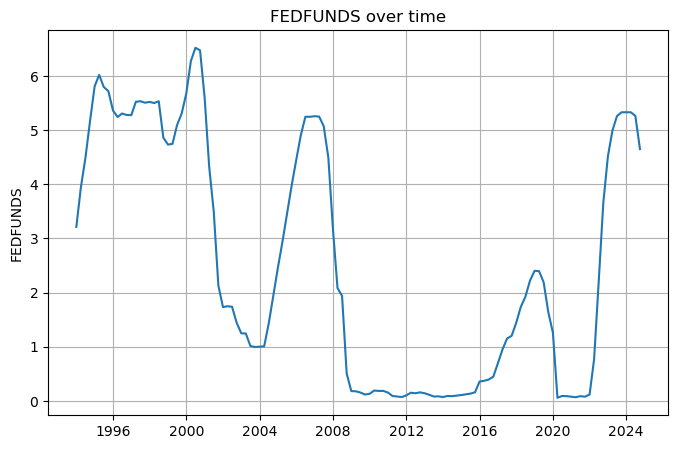

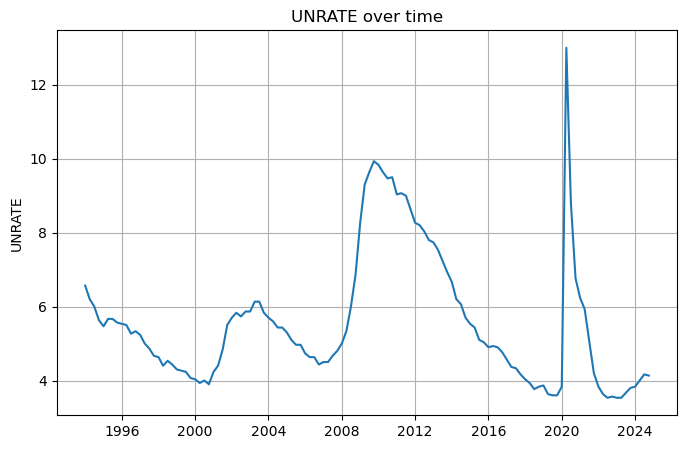

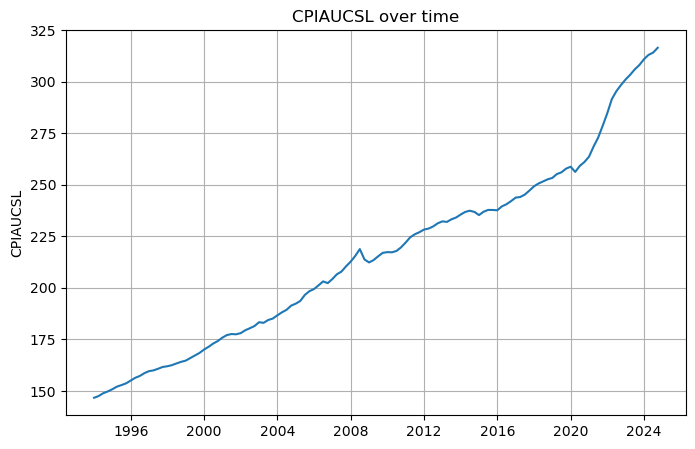

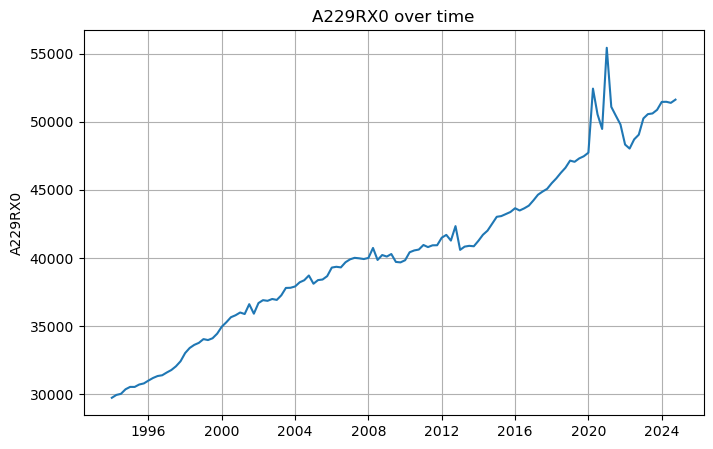

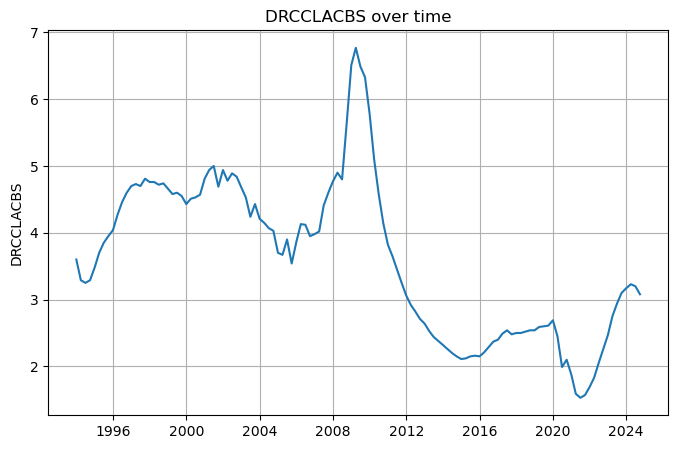

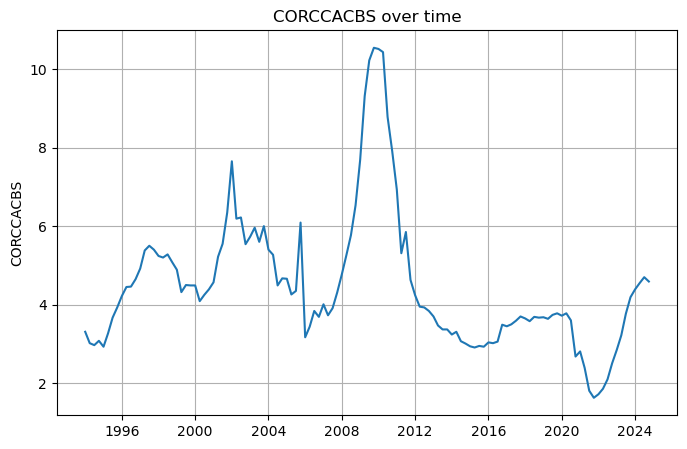

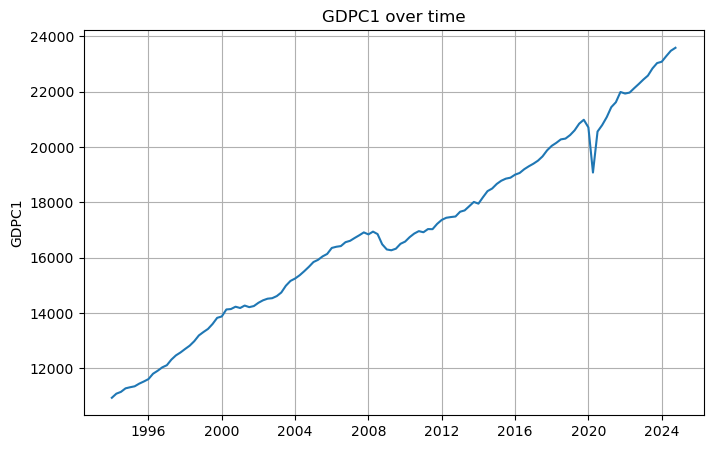

In [39]:
# Plot each variables (raw)
for col in df_raw.columns[1:]:
    plt.figure(figsize = (8,5))
    plt.plot(df_raw['observation_date'], df_raw[col])
    plt.title(f'{col} over time')
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

In [13]:
# Stationarity check
for col in df_raw.columns[1:]:
    if adfuller(df_raw[col])[1]>0.05:
        print(col)

FEDFUNDS
CPIAUCSL
A229RX0
DRCCLACBS
GDPC1


In [41]:
# Transformation of non-stationary data
FEDFUNDS_diff = FEDFUNDS['FEDFUNDS'].diff().dropna()
logCPI = np.log(CPIAUCSL['CPIAUCSL'])
logCPI_diff = logCPI.diff().dropna()
logIncome = np.log(A229RX0['A229RX0'])
logIncome_diff = logIncome.diff().dropna()
Delinq_diff = DRCCLACBS['DRCCLACBS'].diff().dropna()
logGDP = np.log(GDPC1['GDPC1'])
logGDP_diff = logGDP.diff().dropna()

df_transformed = pd.concat(
    [FEDFUNDS_diff, logCPI_diff, logIncome_diff, Delinq_diff, logGDP_diff],
    axis = 1)
for col in df_transformed.columns:
    if adfuller(df_transformed[col])[1]>0.05:
        print(col)

In [43]:
obs_date = pd.to_datetime(FEDFUNDS['observation_date'])
obs_date = obs_date.iloc[1:]
UNRATE = pd.read_csv('UNRATE_quarterly.csv')
UNRATE = UNRATE['UNRATE']
UNRATE = UNRATE.iloc[1:]
ChargeOff = CORCCACBS['CORCCACBS']
ChargeOff = ChargeOff.iloc[1:]

endog_1 = pd.concat([Delinq_diff, FEDFUNDS_diff], axis = 1)
endog_1.set_index(obs_date, inplace = True)
endog_1 = pd.DataFrame(endog_1)

endog_2 = pd.concat([ChargeOff, FEDFUNDS_diff], axis = 1)
endog_2.set_index(obs_date, inplace = True)
endog_2 = pd.DataFrame(endog_2)

exog = pd.concat([logCPI_diff, logIncome_diff, logGDP_diff, UNRATE], axis = 1) 
exog.set_index(obs_date, inplace = True)
exog = pd.DataFrame(exog)

In [49]:
print(exog)
print(CPIAUCSL['CPIAUCSL'])

                  CPIAUCSL   A229RX0     GDPC1    UNRATE
observation_date                                        
1994-04-01        0.005664  0.006981  0.013461  6.200000
1994-07-01        0.009221  0.002668  0.005829  6.000000
1994-10-01        0.005804  0.011150  0.011391  5.633333
1995-01-01        0.007318  0.005714  0.003542  5.466667
1995-04-01        0.008142 -0.000065  0.002979  5.666667
...                    ...       ...       ...       ...
2023-10-01        0.006890  0.005255  0.008405  3.800000
2024-01-01        0.009097  0.011328  0.002096  3.833333
2024-04-01        0.006798  0.000214  0.008816  4.000000
2024-07-01        0.003466 -0.001542  0.008214  4.166667
2024-10-01        0.007471  0.004588  0.004588  4.133333

[123 rows x 4 columns]
0      146.700000
1      147.533333
2      148.900000
3      149.766667
4      150.866667
          ...    
119    308.158333
120    310.974333
121    313.095667
122    314.182667
123    316.538667
Name: CPIAUCSL, Length: 124, dtype: f

In [19]:
# VAR (delinquency)
model_delinq = VAR(endog_1)
lag_order_delinq = model_delinq.select_order(maxlags = 4)
print(lag_order_delinq.summary())

var_model_delinq = model_delinq.fit(lag_order_delinq.selected_orders['aic'])
print(var_model_delinq.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -4.699      -4.653    0.009102      -4.680
1     -5.593*     -5.453*   0.003725*     -5.536*
2      -5.554      -5.321    0.003872      -5.459
3      -5.511      -5.184    0.004043      -5.378
4      -5.476      -5.055    0.004190      -5.305
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Oct, 2025
Time:                     16:11:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.48537
Nobs:                     122.000    HQIC:                  -5.56727
Log likelihood:           2.79890    FPE:                 0.00361285
AIC:                     -5.62328    Det(Omega_mle):      0.00344152
------------------------------

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [27]:
# VARX (delinquency)
varx_model_delinq = VARMAX(endog_1, exog = exog, order = (lag_order_delinq.selected_orders['aic'], 0))
varx_result = varx_model_delinq.fit(maxiter = 1000, disp = False)
print(varx_result.summary())

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


                               Statespace Model Results                              
Dep. Variable:     ['DRCCLACBS', 'FEDFUNDS']   No. Observations:                  123
Model:                               VARX(1)   Log Likelihood                  31.053
                                 + intercept   AIC                            -28.106
Date:                       Sat, 18 Oct 2025   BIC                             19.701
Time:                               17:30:54   HQIC                            -8.687
Sample:                           04-01-1994                                         
                                - 10-01-2024                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):             0.01, 0.59   Jarque-Bera (JB):         27.29, 20.52
Prob(Q):                        0.91, 0.44   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 0.65   Skew:        

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# VAR (charge-off)
model_chargeoff = VAR(endog_2)
lag_order_chargeoff = model_chargeoff.select_order(maxlags = 4)
print(lag_order_chargeoff.summary())

var_model_chargeoff = model_chargeoff.fit(lag_order_chargeoff.selected_orders['aic'])
print(var_model_chargeoff.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0     -0.5831     -0.5364      0.5582     -0.5641
1      -3.406     -3.266*     0.03317     -3.349*
2      -3.355      -3.122     0.03490      -3.261
3      -3.410      -3.083     0.03305      -3.277
4     -3.480*      -3.060    0.03082*      -3.310
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Oct, 2025
Time:                     16:47:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.05986
Nobs:                     119.000    HQIC:                  -3.30953
Log likelihood:          -112.634    FPE:                  0.0308181
AIC:                     -3.48023    Det(Omega_mle):       0.0266367
------------------------------

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [29]:
# VARX (charge-off)
varx_model_chargeoff = VARMAX(endog_2, exog = exog, order = (lag_order_chargeoff.selected_orders['aic'], 0))
varx_result = varx_model_chargeoff.fit(maxiter = 1000, disp = False)
print(varx_result.summary())

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


                               Statespace Model Results                              
Dep. Variable:     ['CORCCACBS', 'FEDFUNDS']   No. Observations:                  123
Model:                               VARX(4)   Log Likelihood                 -99.970
                                 + intercept   AIC                            257.940
Date:                       Sat, 18 Oct 2025   BIC                            339.494
Time:                               17:33:59   HQIC                           291.067
Sample:                           04-01-1994                                         
                                - 10-01-2024                                         
Covariance Type:                         opg                                         
Ljung-Box (L1) (Q):             0.09, 0.23   Jarque-Bera (JB):        455.26, 17.11
Prob(Q):                        0.76, 0.63   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.45, 0.76   Skew:        

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
